In [1]:
import sys
sys.path.append('../')

In [2]:
%matplotlib inline

from datetime import datetime

import matplotlib.pyplot as plt
import seaborn as sns

from water import data

sns.set_style('darkgrid')
sns.set(rc={'figure.figsize':(13, 9), 'figure.max_open_warning': 50})
sns.set_context('talk')

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

In [3]:
df = data.load()

In [4]:
def filter_year(df, yr):
    return (df.index >= str(yr)) & (df.index < str(yr + 1))

def plot_year(df, yr, site, ax=None, xlim=None, ylim=None):
    x = df.loc[filter_year(df, yr), site].dropna()
    x_interpolated = x.resample('D').mean().interpolate()
    if ax is None:
        _, ax = plt.subplots(1)
    ax.set_yscale('log')
    if not x.size:
        return
    ax.plot([x.index[0], x.index[-1]], [1000, 1000], 'k--', alpha=0.3) # threshold
    line = ax.plot(x_interpolated.index, x_interpolated.values, '-')[0]
    ax.plot(x.index, x.values, 'o', color=line.get_color())
    if xlim is not None:
        ax.set_xlim(xlim)
    if ylim is not None:
        ax.set_ylim(ylim)

def plot_all_years_site(df, site):
    years = list(range(2010, 2019))
    f, axs = plt.subplots(len(years), sharey=True, figsize=(14, 14))
    axs[0].set_title(' '.join(site.split('_')).title())
    for ax, yr in zip(axs, years):
        plot_year(df, yr, site, ax, xlim=[datetime(yr, 5, 20), datetime(yr, 9, 10)], ylim=[1, 10**5])
        ax.set_yticks([10, 10**4])
        ax.set_ylabel(yr)

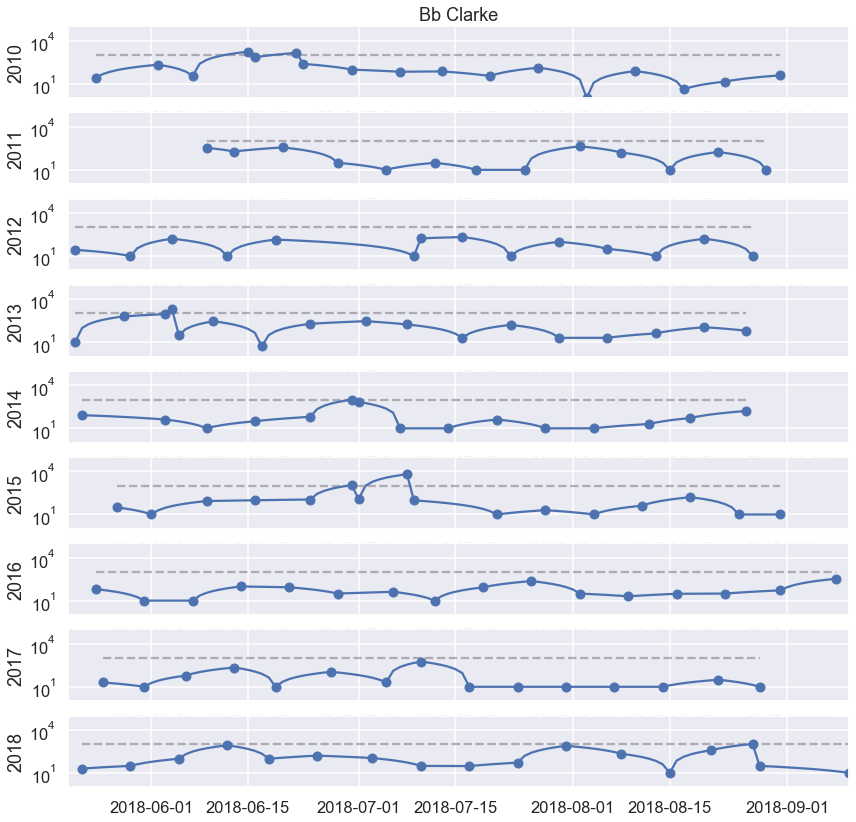

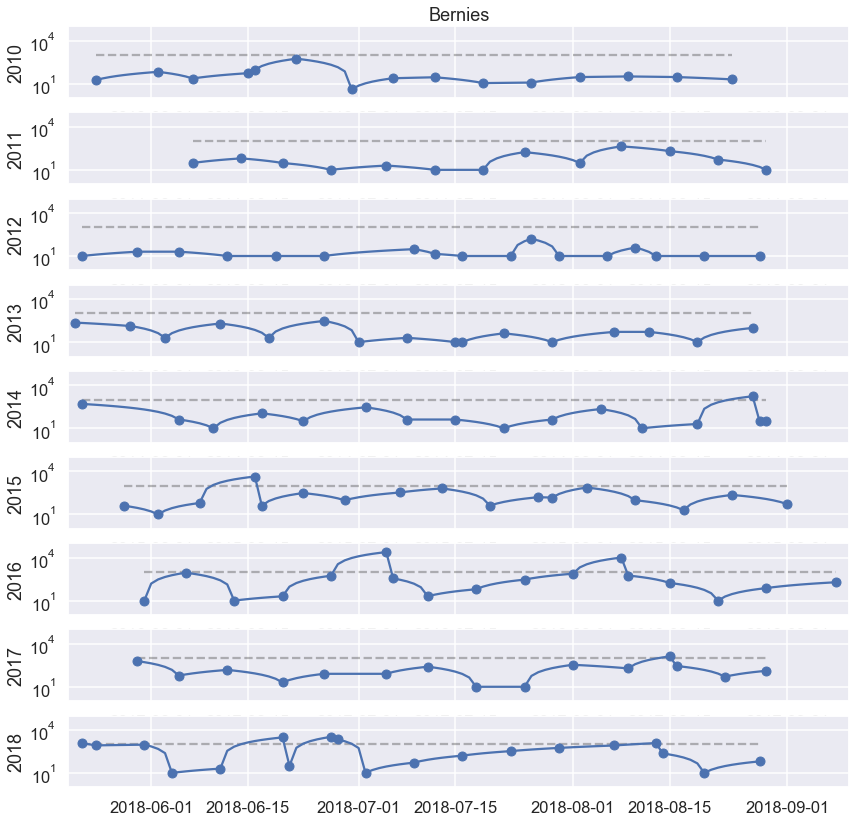

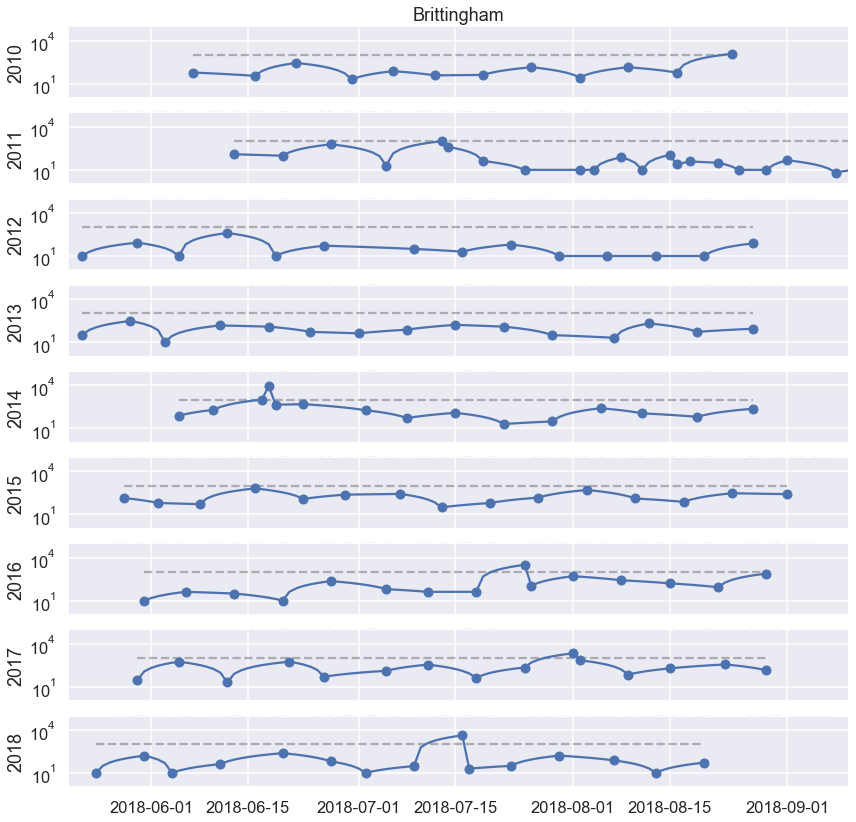

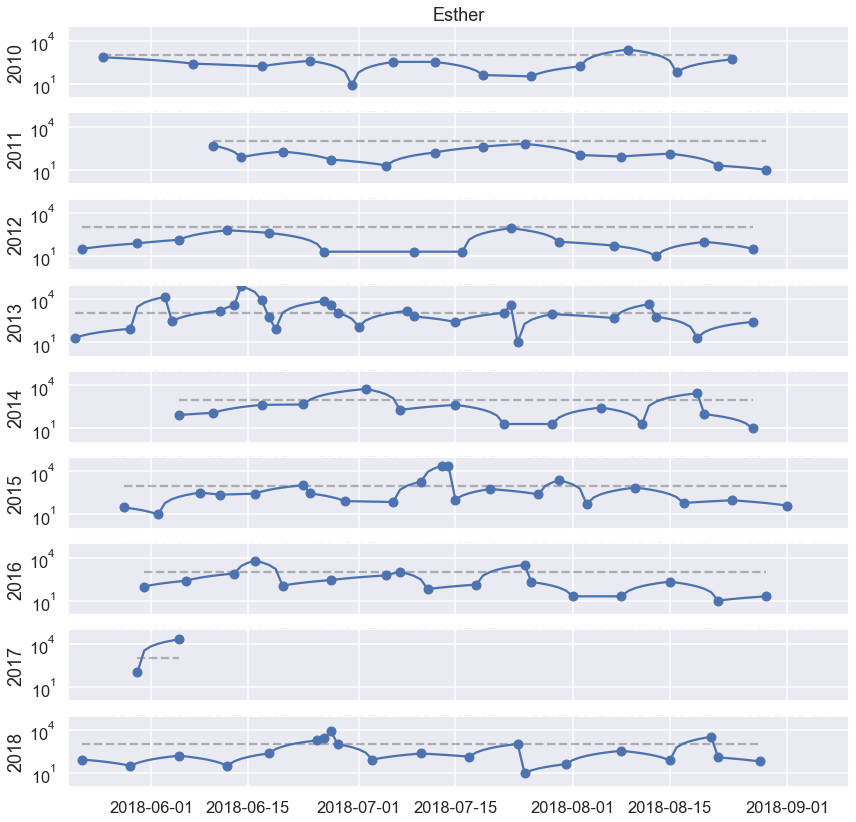

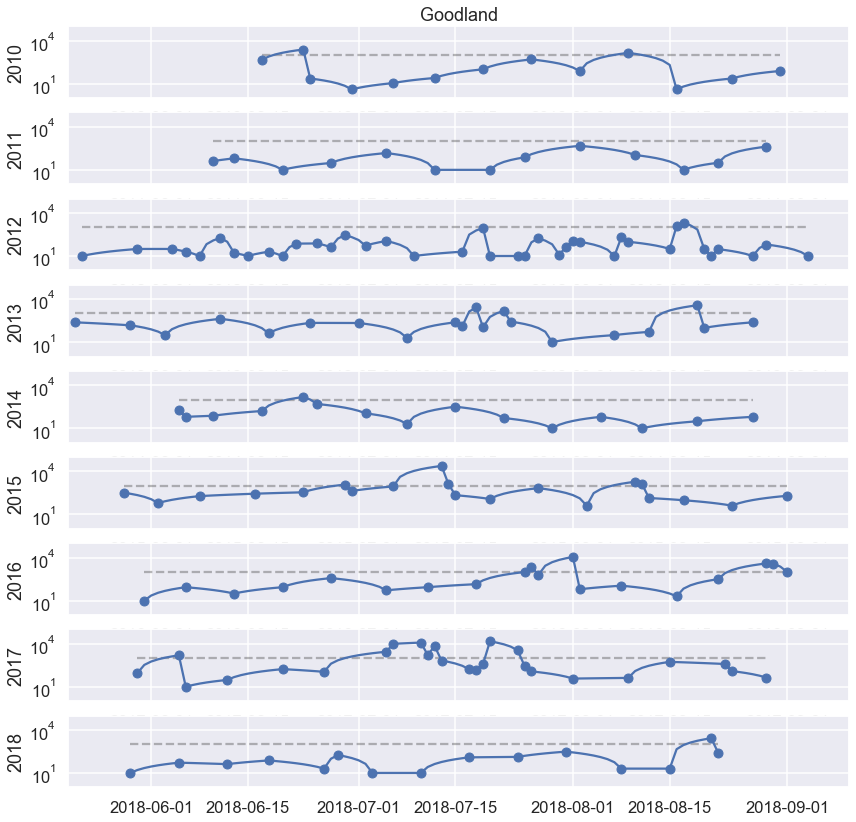

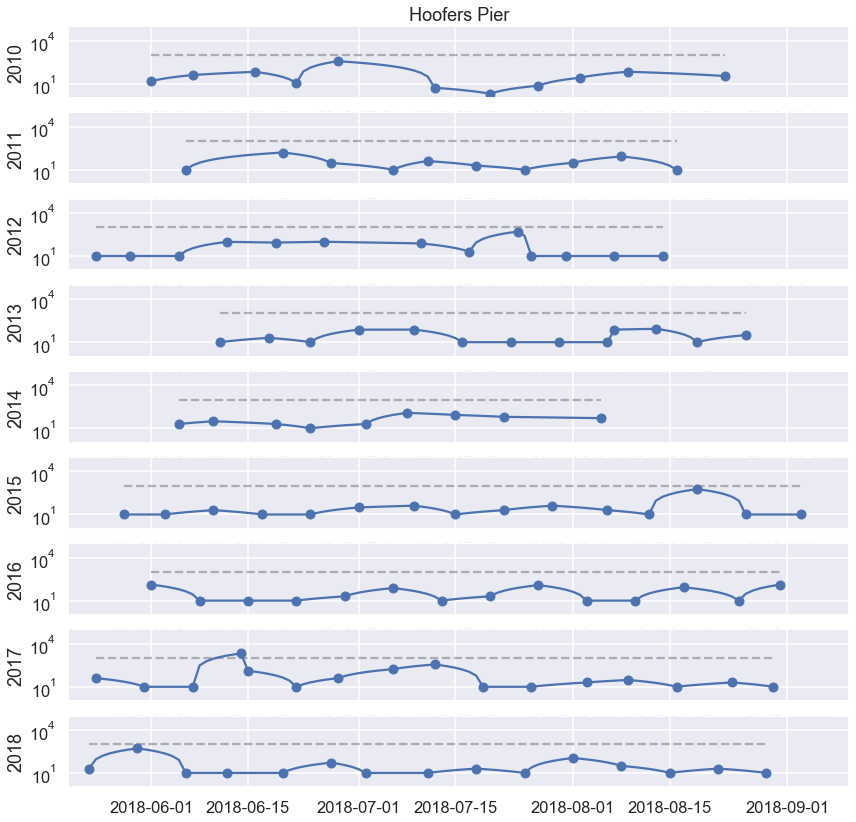

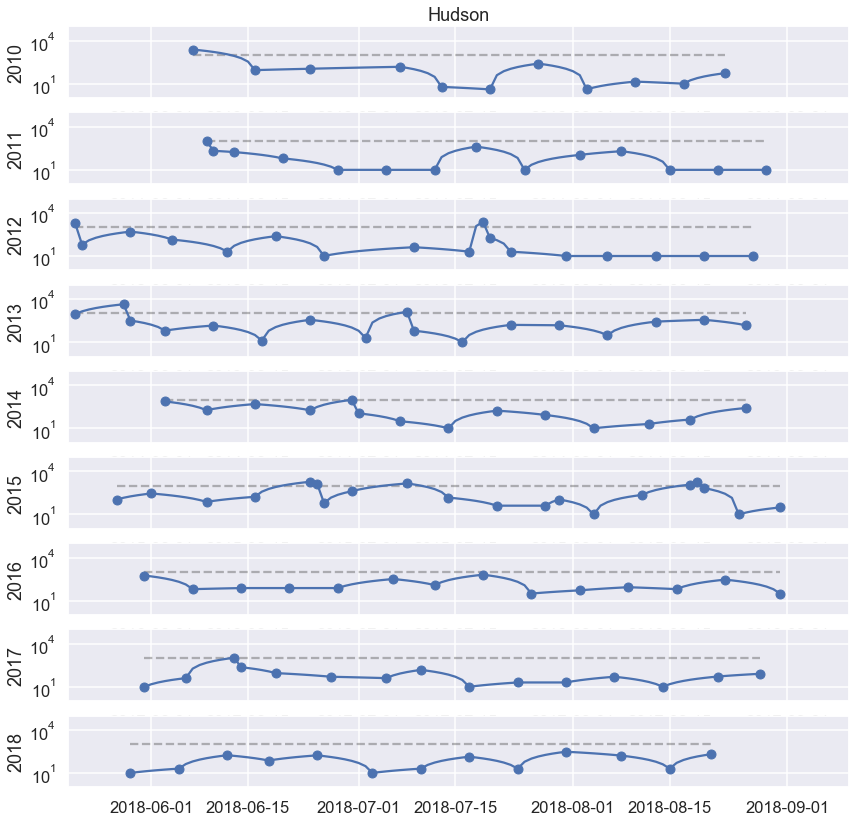

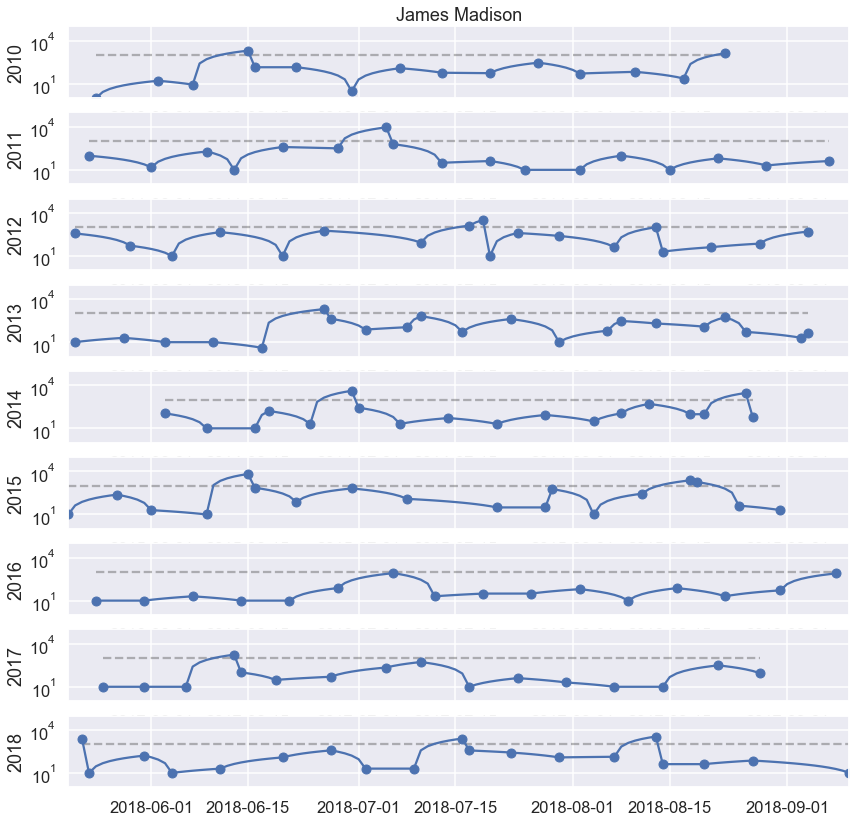

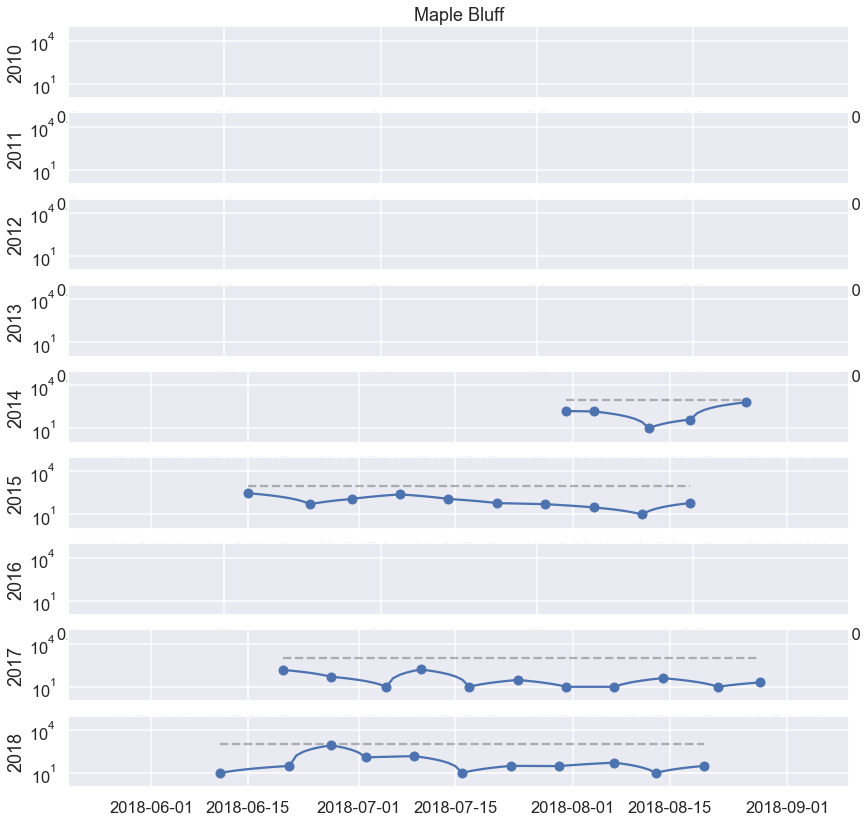

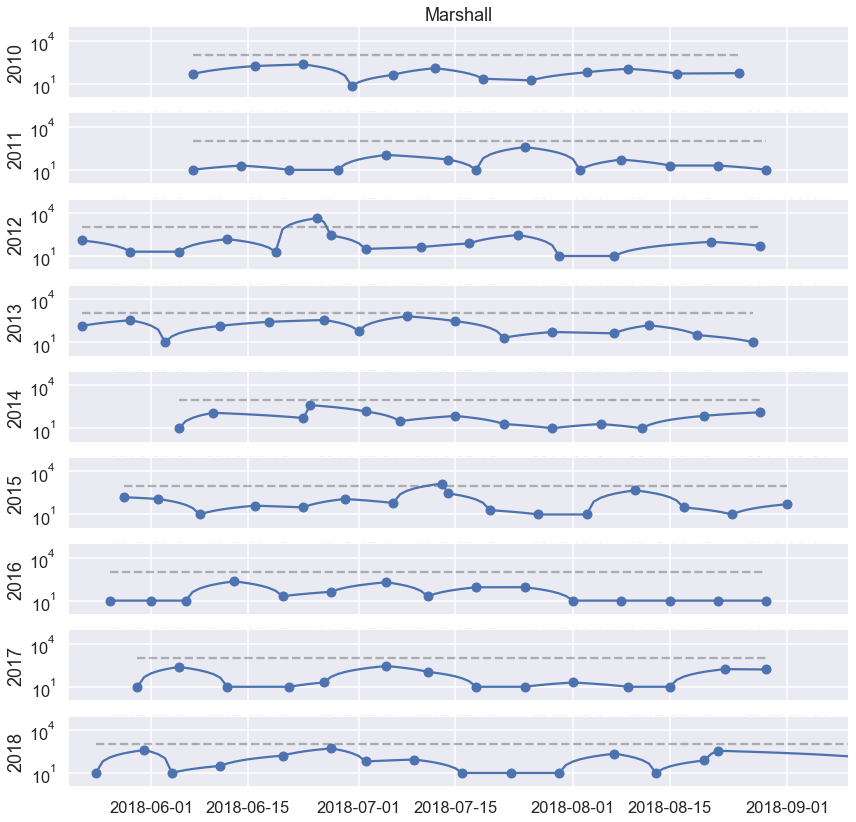

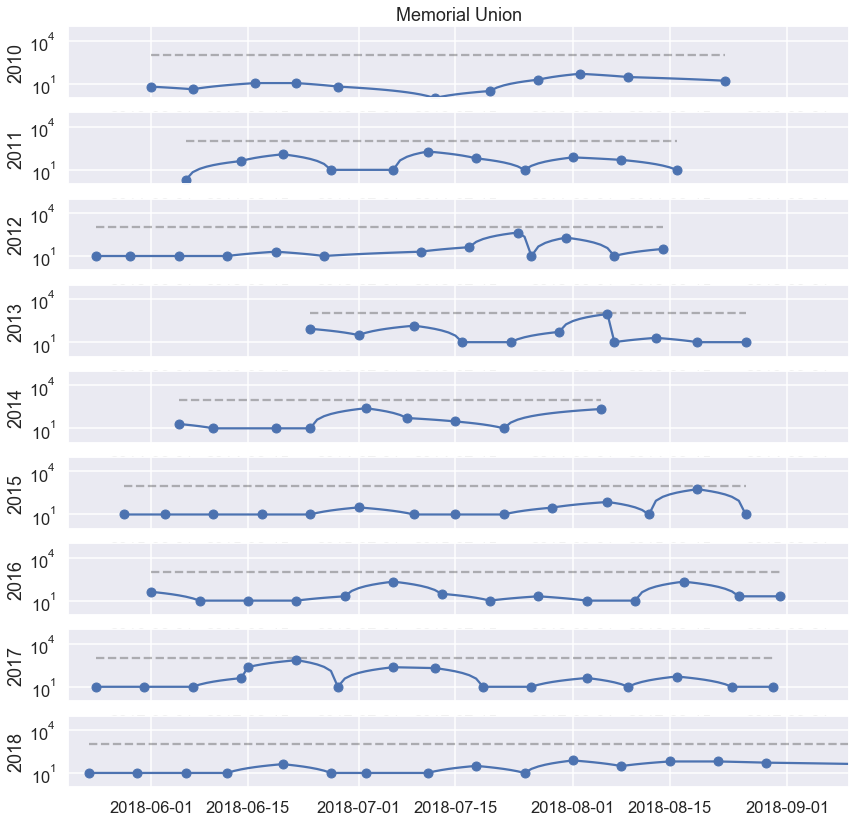

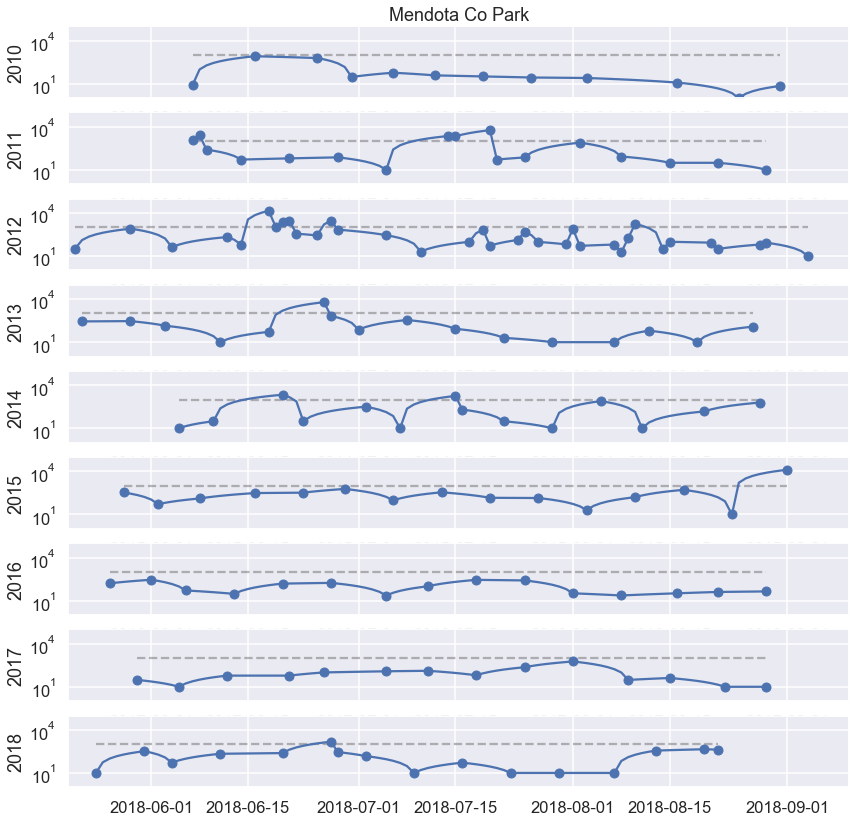

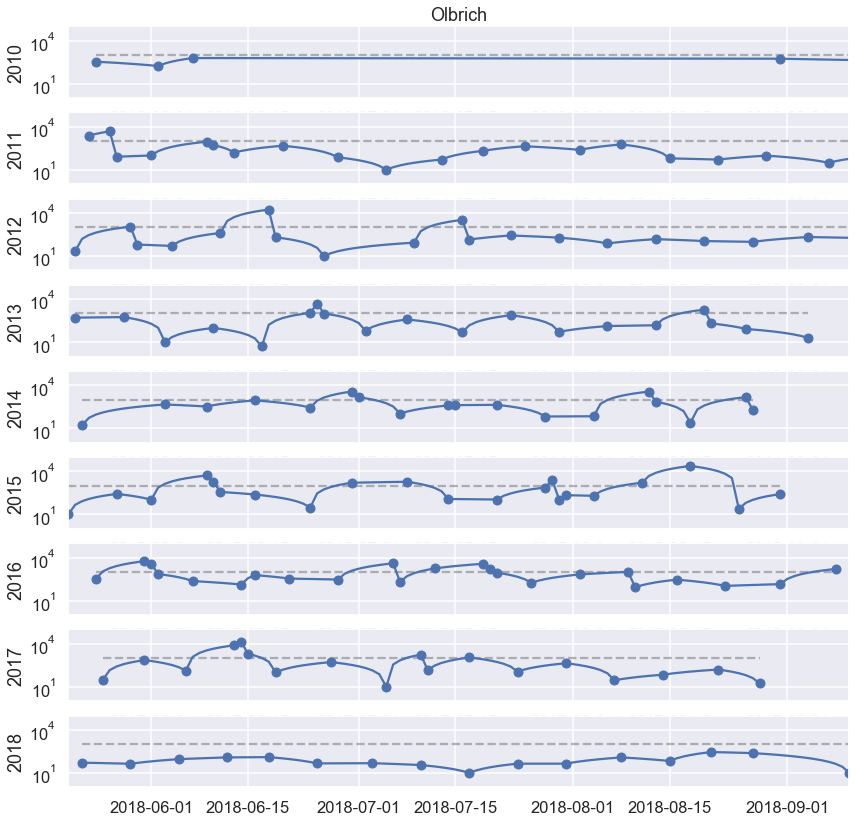

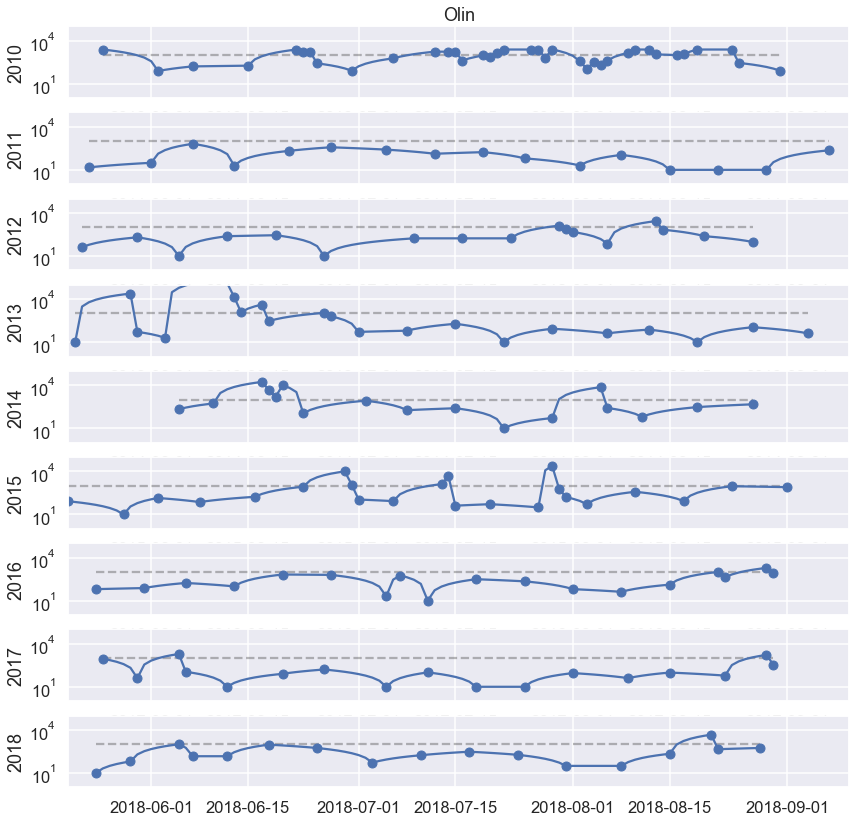

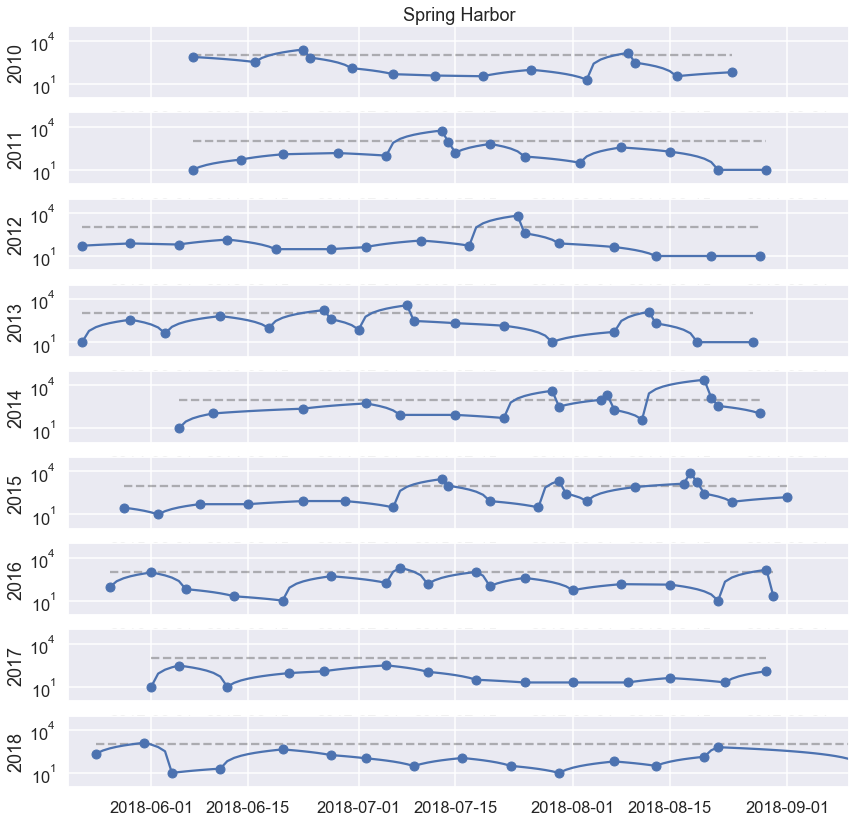

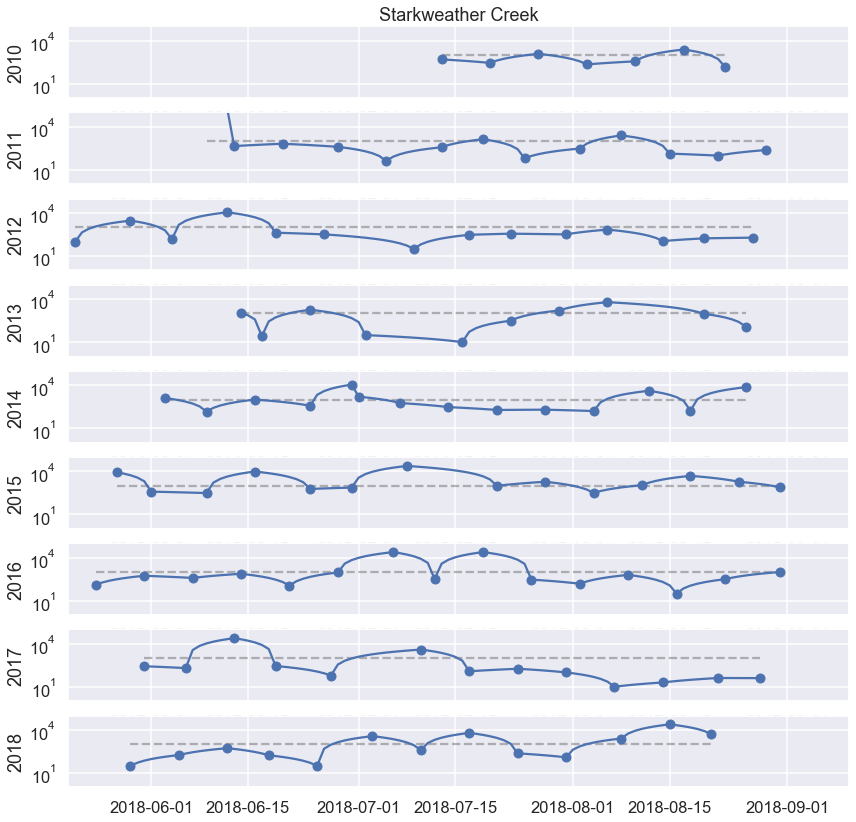

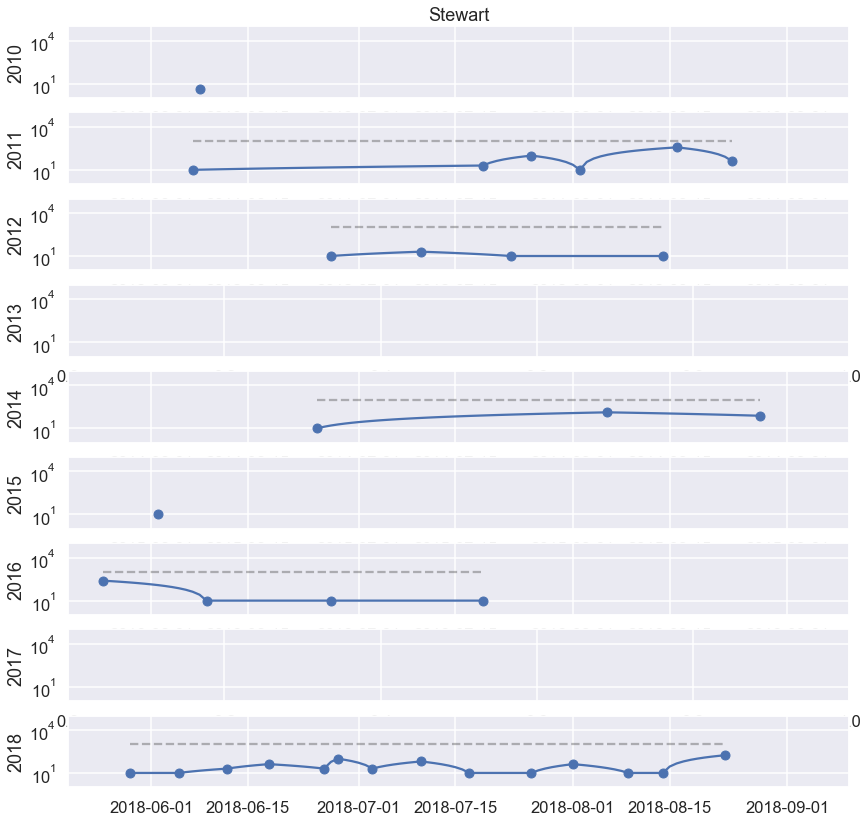

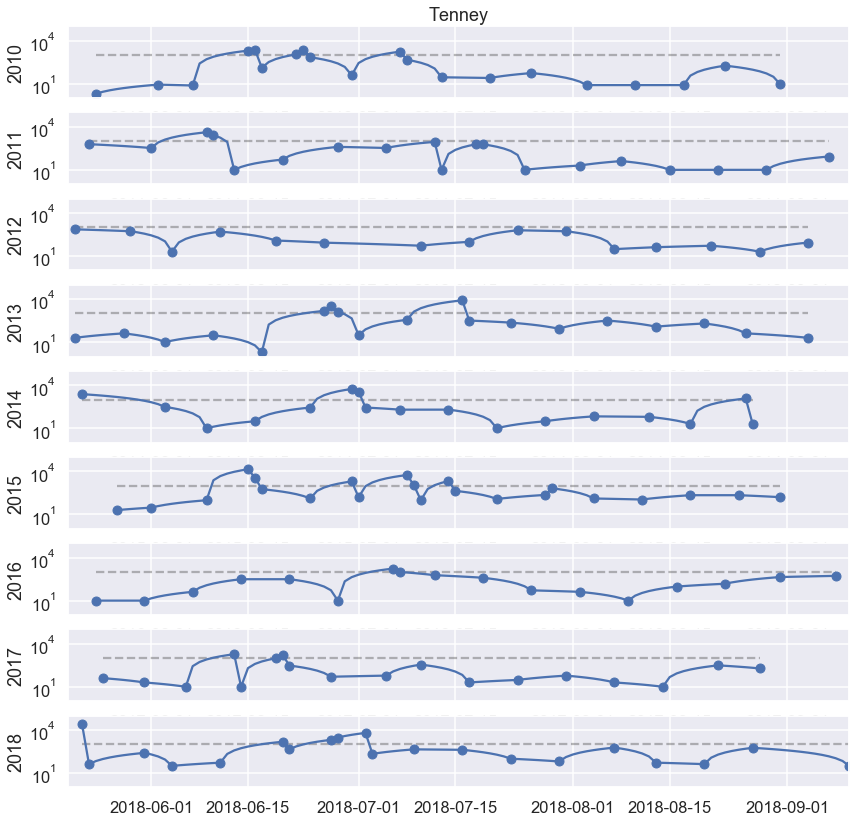

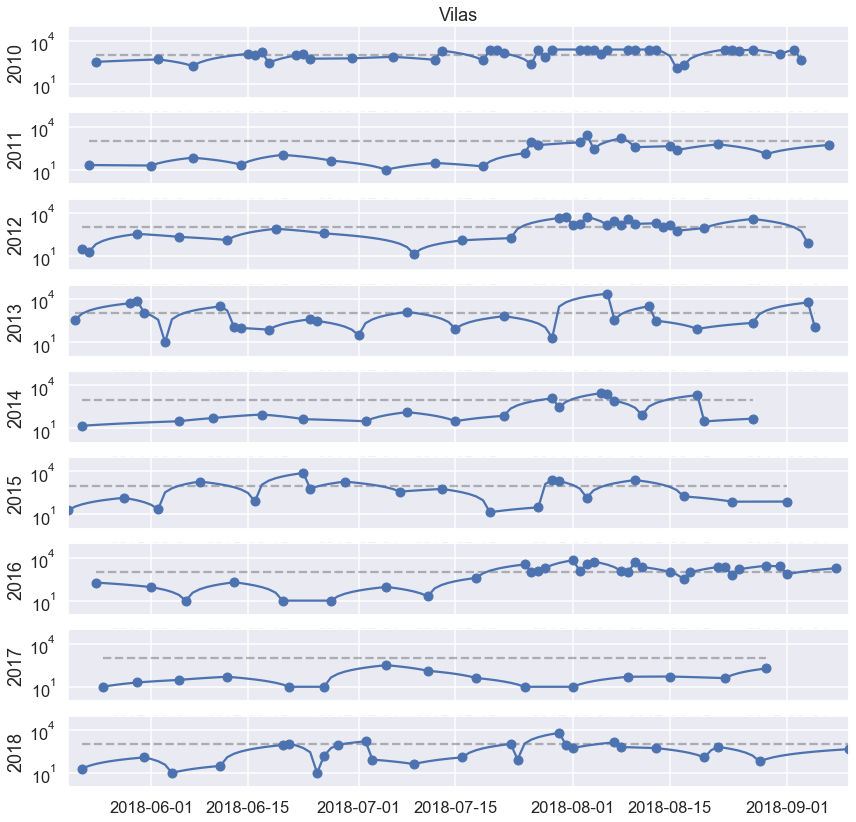

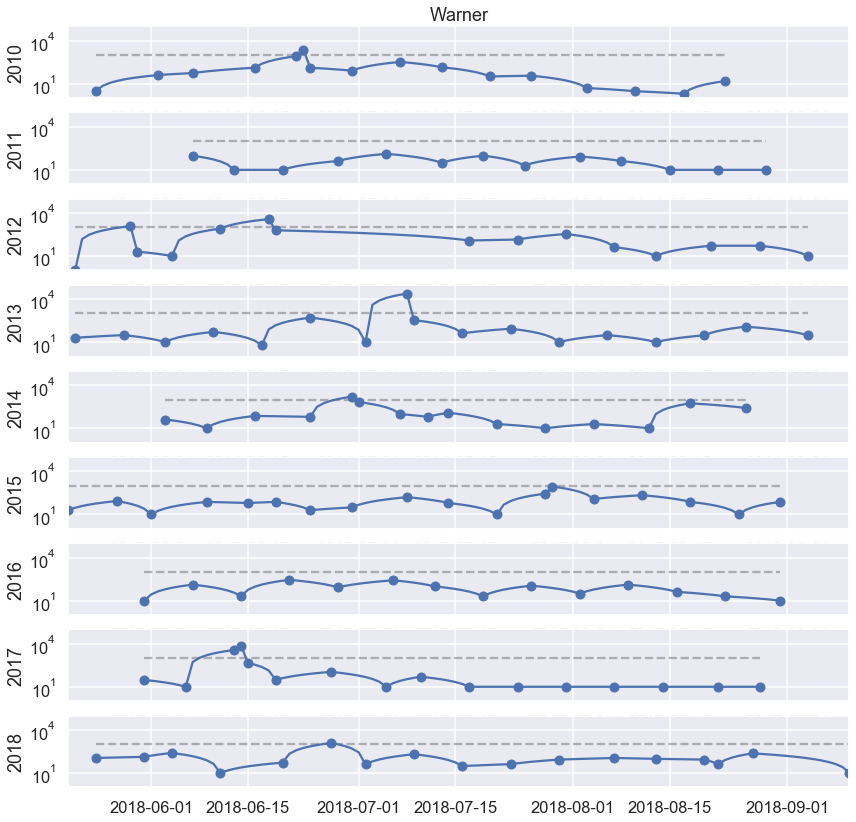

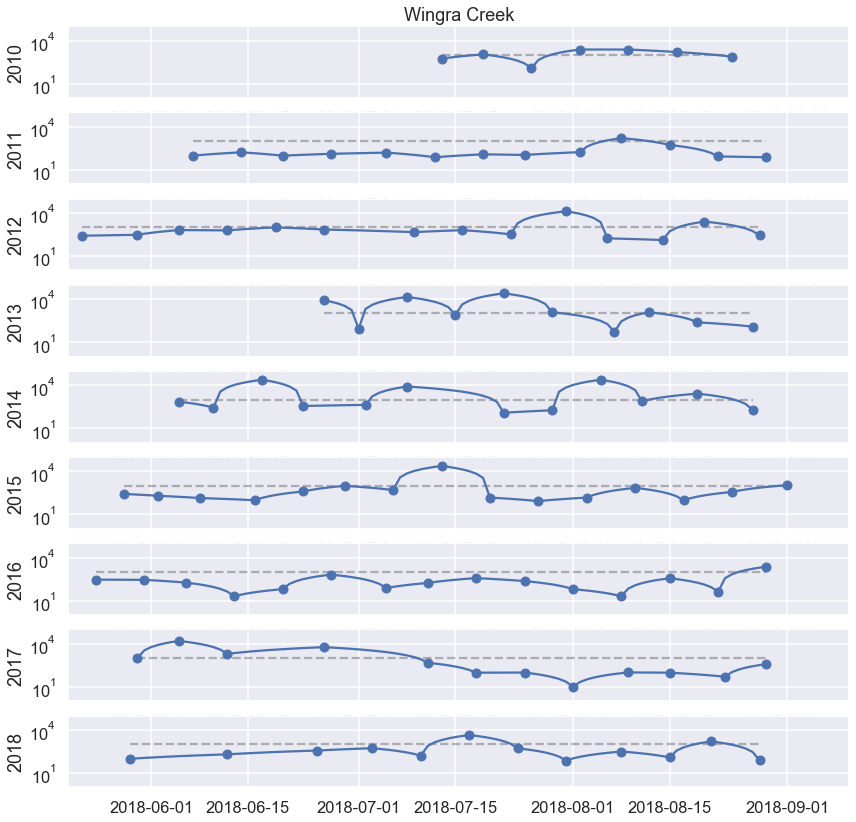

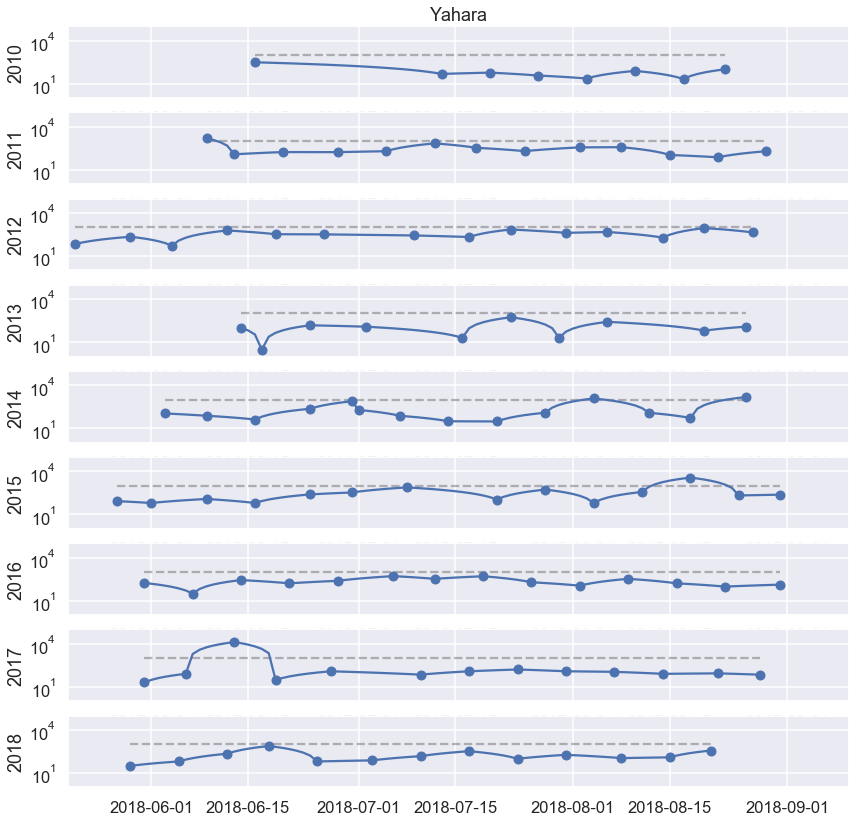

In [5]:
for site in df.columns:
    if df[site].notna().sum() > 30:
        plot_all_years_site(df, site)

In [6]:
def plot_exceedances(df, site, ax):
    df_no_nan = df[site].dropna().copy()
    changes = (df_no_nan > 1000).astype(float).diff()
    changes[0] = float(df_no_nan.iloc[0] > 1000)
    changes[-1] = float(changes[-1] or df_no_nan.iloc[-1] > 1000)
    
    starts = df_no_nan[changes == 1].index.tolist()
    stops = df_no_nan[changes == -1].index.tolist()

    for start, stop in zip(starts, stops):
        if (stop - start).days > 100:
            # multi-year, ignore
            continue
        exceedance_df = df_no_nan.loc[(df_no_nan.index >= start) & (df_no_nan.index <= stop)].copy()
        exceedance_df.index = (exceedance_df.index - exceedance_df.index[0]).days
        ax.plot(exceedance_df.index.values, exceedance_df.values, '.-', color=sns.color_palette()[0], alpha=0.5)
    ax.set_yscale('log')
    ax.set_ylabel(' '.join(site.split('_')).title(), rotation=0)
    ax.yaxis.set_label_position("right")

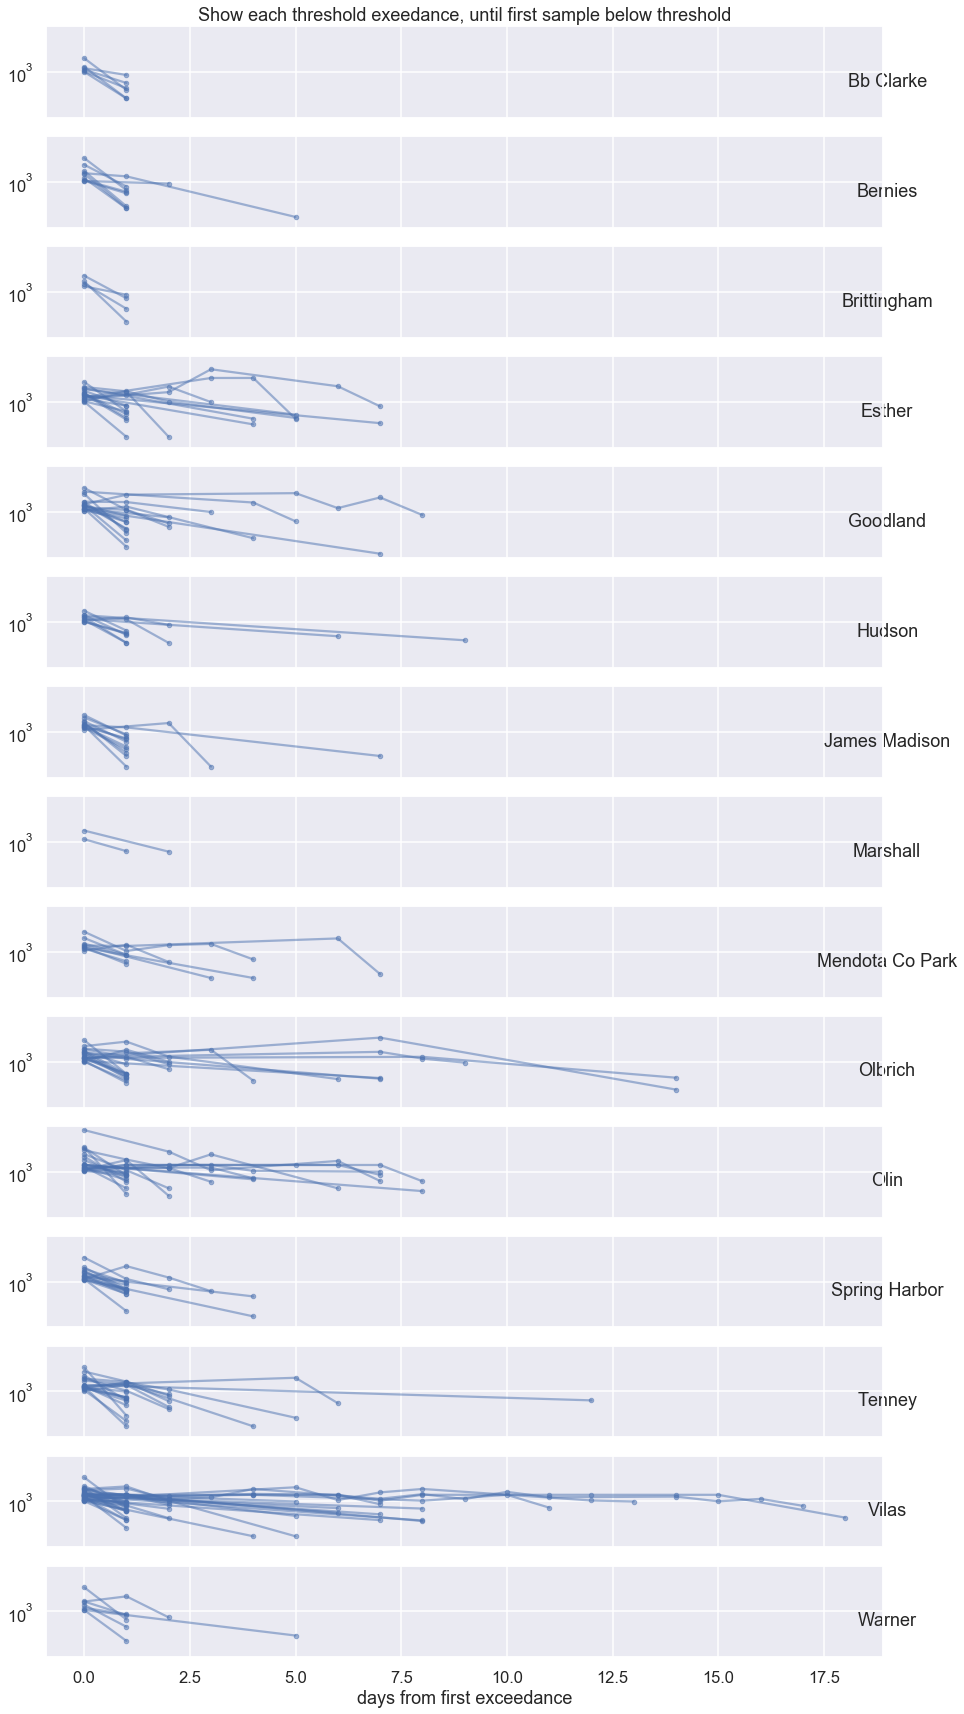

In [7]:
sites_to_show = []
for site in df:
    if (
        df[site].notna().sum() > 30
        and (df[site] > 1000).sum() > 1
        and site not in ['starkweather_creek', 'yahara', 'wingra_creek']  # not beaches
    ):
        sites_to_show.append(site)

_, axs = plt.subplots(len(sites_to_show), sharex=True, sharey=True, figsize=(15, 30))
for ax, site in zip(axs, sites_to_show):
    plot_exceedances(df, site, ax)
axs[0].set_title('Show each threshold exeedance, until first sample below threshold')
axs[-1].set_xlabel('days from first exceedance');